# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [ ]:
!pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

In [2]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path='/content/drive/MyDrive/Colab Notebooks/NLP/A6'

## 1. Loading our MNLI part of the GLUE dataset

In [5]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [6]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [7]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [8]:
import numpy as np
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

<img src = "figures/BERT_embed.png" width=500>

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing

In [10]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [12]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [13]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [14]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [15]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=64, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=64, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=64, collate_fn=data_collator)

In [19]:
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([64]), torch.Size([64, 121]), torch.Size([64, 121]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture
In the present work, the student - DistilBERT - has the same general architecture as BERT.
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2.
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers.
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher).
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [20]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

####
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [21]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [22]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [ ]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [24]:
def create_student_model(configuration):
    return type(teacher_model)(configuration)

In [25]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    mode = None
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, mode=mode)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        if mode == 'odd':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
        elif mode == 'even':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i+1].state_dict())
        elif mode == 'top':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())
        elif mode == 'bottom':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[len(student_encoding_layers)+i].state_dict())
        else:
            raise ValueError(f'Invalid mode: {mode}')
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())
    return student

In [26]:
models = {}
for mode in ['Top', 'Bottom', 'Odd', 'Even']:
    student = create_student_model(configuration)
    models[mode] = distill_bert_weights(teacher=teacher_model, student=student, mode=mode.lower())

In [27]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismatch found at', key_item_1[0])
                break
    if models_differ == 0:
        print('Models match perfectly.')
        raise Exception

In [28]:
compare_models(models['Top'], models['Odd'])

Mismatch found at bert.encoder.layer.1.attention.self.query.weight


In [29]:
compare_models(models['Top'], models['Bottom'])

Mismatch found at bert.encoder.layer.0.attention.self.query.weight


The first mismatch of Top and Odd is at layer1 not layer 0 because they share the first layer (both are from teacher's layer0 or 1 from {1,2,3,...,12})

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
for mode, model in models.items():
    print(f'Student parameters {mode}:', count_parameters(model))

Teacher parameters : 109484547
Student parameters Top: 66957315
Student parameters Bottom: 66957315
Student parameters Odd: 66957315
Student parameters Even: 66957315


In [31]:
count_parameters(models['Top'])/count_parameters(teacher_model) * 100

61.15686353435797

In [32]:
#It has ~40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [33]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

In [34]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [35]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [36]:
for _, model in models.items():
    model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [37]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

## 8. Metric

In [ ]:
!pip3 install evaluate

In [39]:
# import numpy as np
# import evaluate
# # Get the metric function
# if task_name is not None:
#     metric = evaluate.load("glue", task_name)
# else:
#     metric = evaluate.load("accuracy")

## 9. Train

In [40]:
import torch
from tqdm.auto import tqdm
import pickle
import numpy as np
import evaluate

losses = {}

for mode, model in models.items():

    ######## reinit training feedback
    criterion_div = DistillKL()
    criterion_cos = nn.CosineEmbeddingLoss()

    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
        )

    if task_name is not None:
        metric = evaluate.load("glue", task_name)
    else:
        metric = evaluate.load("accuracy")
    ########

    progress_bar = tqdm(range(num_training_steps), desc=f'{mode} Layer')
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_accs = []

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch)
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()

            # cls loss
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()

            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3

            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls:  {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div:  {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos:  {train_loss_cos/len(train_dataloader):.4f}')

        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions,
                references=batch["labels"])

        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy']
        eval_accs.append(eval_metric['accuracy'])
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting

        print(f"  • Eval Acc:  {eval_metric['accuracy']:.4f}")
        print(f"  • Eval Loss: {eval_loss / len(eval_dataloader):.4f}")

    print('Avg Metric', eval_metrics/num_epochs)
    losses[mode+' layer'] = {'train_losses': train_losses,
                             'train_losses_cls': train_losses_cls,
                             'train_losses_div': train_losses_div,
                             'train_losses_cos': train_losses_cos,
                             'eval_losses': eval_losses,
                             'eval_accs': eval_accs}

    torch.save(model.state_dict(), f'{file_path}/{mode} layer model.pt')

Top Layer:   0%|          | 0/785 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.3550:
  - Loss_cls:  0.9708
  - Loss_div:  0.0431
  - Loss_cos:  0.0509
  • Eval Acc:  0.6540
  • Eval Loss: 0.8761
Epoch at 2: Train loss 0.3144:
  - Loss_cls:  0.7948
  - Loss_div:  0.0989
  - Loss_cos:  0.0495
  • Eval Acc:  0.6650
  • Eval Loss: 0.8472
Epoch at 3: Train loss 0.2834:
  - Loss_cls:  0.6557
  - Loss_div:  0.1438
  - Loss_cos:  0.0505
  • Eval Acc:  0.6640
  • Eval Loss: 0.8177
Epoch at 4: Train loss 0.2644:
  - Loss_cls:  0.5705
  - Loss_div:  0.1721
  - Loss_cos:  0.0506
  • Eval Acc:  0.6640
  • Eval Loss: 0.8099
Epoch at 5: Train loss 0.2541:
  - Loss_cls:  0.5257
  - Loss_div:  0.1862
  - Loss_cos:  0.0506
  • Eval Acc:  0.6640
  • Eval Loss: 0.8087
Avg Metric 0.6622000000000001


Bottom Layer:   0%|          | 0/785 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.3803:
  - Loss_cls:  1.0867
  - Loss_div:  0.0125
  - Loss_cos:  0.0418
  • Eval Acc:  0.4800
  • Eval Loss: 1.0389
Epoch at 2: Train loss 0.3578:
  - Loss_cls:  0.9907
  - Loss_div:  0.0376
  - Loss_cos:  0.0449
  • Eval Acc:  0.5920
  • Eval Loss: 0.9412
Epoch at 3: Train loss 0.3271:
  - Loss_cls:  0.8539
  - Loss_div:  0.0797
  - Loss_cos:  0.0478
  • Eval Acc:  0.5990
  • Eval Loss: 0.9194
Epoch at 4: Train loss 0.2998:
  - Loss_cls:  0.7328
  - Loss_div:  0.1169
  - Loss_cos:  0.0496
  • Eval Acc:  0.6000
  • Eval Loss: 0.9144
Epoch at 5: Train loss 0.2825:
  - Loss_cls:  0.6547
  - Loss_div:  0.1424
  - Loss_cos:  0.0504
  • Eval Acc:  0.5960
  • Eval Loss: 0.9142
Avg Metric 0.5734


Odd Layer:   0%|          | 0/785 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.3687:
  - Loss_cls:  1.0238
  - Loss_div:  0.0303
  - Loss_cos:  0.0520
  • Eval Acc:  0.6220
  • Eval Loss: 0.9196
Epoch at 2: Train loss 0.3245:
  - Loss_cls:  0.8405
  - Loss_div:  0.0841
  - Loss_cos:  0.0491
  • Eval Acc:  0.6470
  • Eval Loss: 0.8509
Epoch at 3: Train loss 0.2918:
  - Loss_cls:  0.6941
  - Loss_div:  0.1314
  - Loss_cos:  0.0500
  • Eval Acc:  0.6670
  • Eval Loss: 0.8260
Epoch at 4: Train loss 0.2703:
  - Loss_cls:  0.5977
  - Loss_div:  0.1627
  - Loss_cos:  0.0506
  • Eval Acc:  0.6670
  • Eval Loss: 0.8144
Epoch at 5: Train loss 0.2592:
  - Loss_cls:  0.5478
  - Loss_div:  0.1789
  - Loss_cos:  0.0508
  • Eval Acc:  0.6620
  • Eval Loss: 0.8181
Avg Metric 0.653


Even Layer:   0%|          | 0/785 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.3664:
  - Loss_cls:  1.0261
  - Loss_div:  0.0268
  - Loss_cos:  0.0462
  • Eval Acc:  0.6360
  • Eval Loss: 0.8938
Epoch at 2: Train loss 0.3243:
  - Loss_cls:  0.8396
  - Loss_div:  0.0850
  - Loss_cos:  0.0484
  • Eval Acc:  0.6480
  • Eval Loss: 0.8472
Epoch at 3: Train loss 0.2932:
  - Loss_cls:  0.7001
  - Loss_div:  0.1302
  - Loss_cos:  0.0492
  • Eval Acc:  0.6620
  • Eval Loss: 0.8195
Epoch at 4: Train loss 0.2745:
  - Loss_cls:  0.6177
  - Loss_div:  0.1568
  - Loss_cos:  0.0489
  • Eval Acc:  0.6680
  • Eval Loss: 0.8057
Epoch at 5: Train loss 0.2632:
  - Loss_cls:  0.5680
  - Loss_div:  0.1732
  - Loss_cos:  0.0484
  • Eval Acc:  0.6720
  • Eval Loss: 0.8036
Avg Metric 0.6572000000000001


In [ ]:
import json
json.dump(losses, open(f'{file_path}/losses.json', 'w'))
print(json.dumps(losses, indent=4))

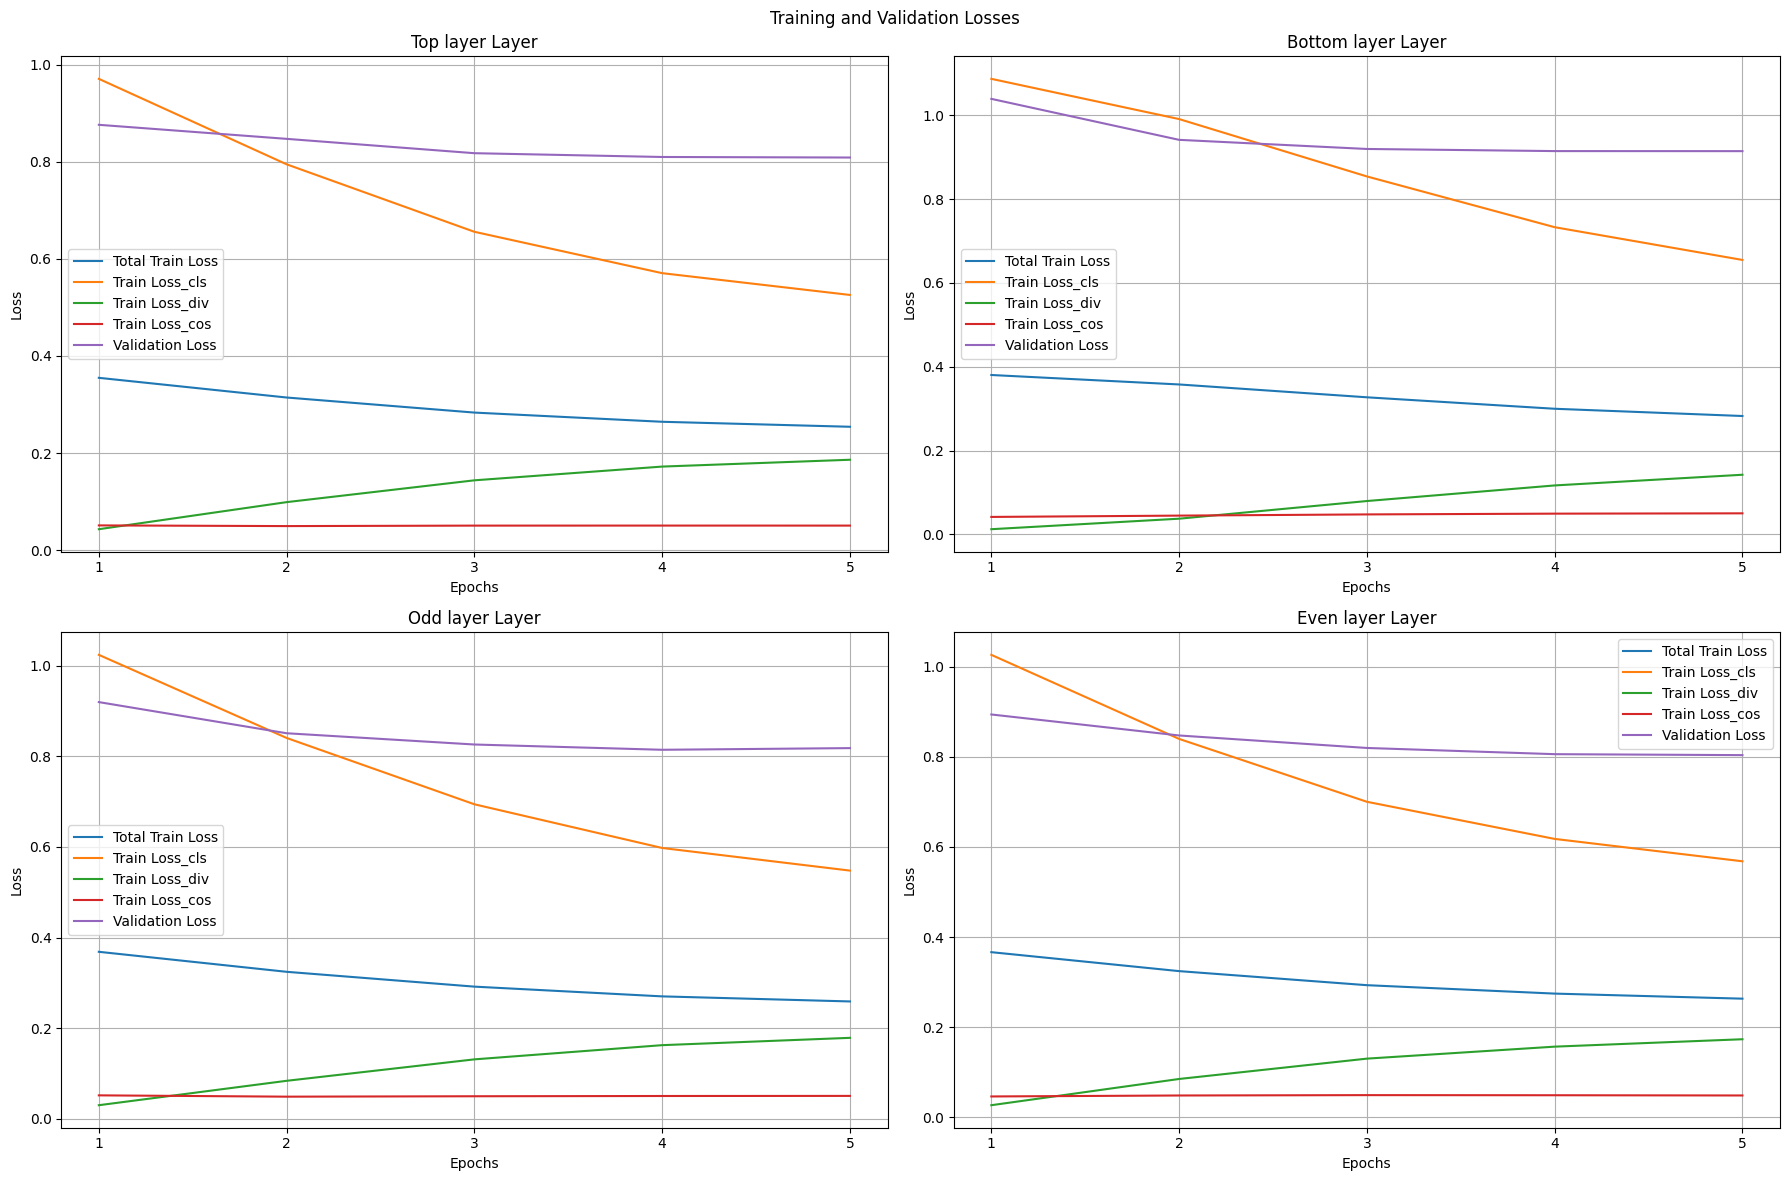

In [48]:
import matplotlib.pyplot as plt

# Plotting
epochs_list = range(1, num_epochs + 1)

fig, axs = plt.subplots(2, 2, figsize=(18,12))

for i, mode in enumerate(losses.keys()):

    splt = axs[i//2, i%2]
    splt.plot(epochs_list, losses[mode]['train_losses'], label='Total Train Loss')
    splt.plot(epochs_list, losses[mode]['train_losses_cls'], label='Train Loss_cls')
    splt.plot(epochs_list, losses[mode]['train_losses_div'], label='Train Loss_div')
    splt.plot(epochs_list, losses[mode]['train_losses_cos'], label='Train Loss_cos')
    splt.plot(epochs_list, losses[mode]['eval_losses'], label='Validation Loss')

    splt.set_title(f'{mode.capitalize()} Layer')
    splt.set_xticks(epochs_list)
    splt.set_xlabel('Epochs')
    splt.set_ylabel('Loss')
    splt.grid()
    splt.legend()

plt.suptitle('Training and Validation Losses')
plt.tight_layout()
plt.savefig(f'{file_path}/losses.png')
plt.show()

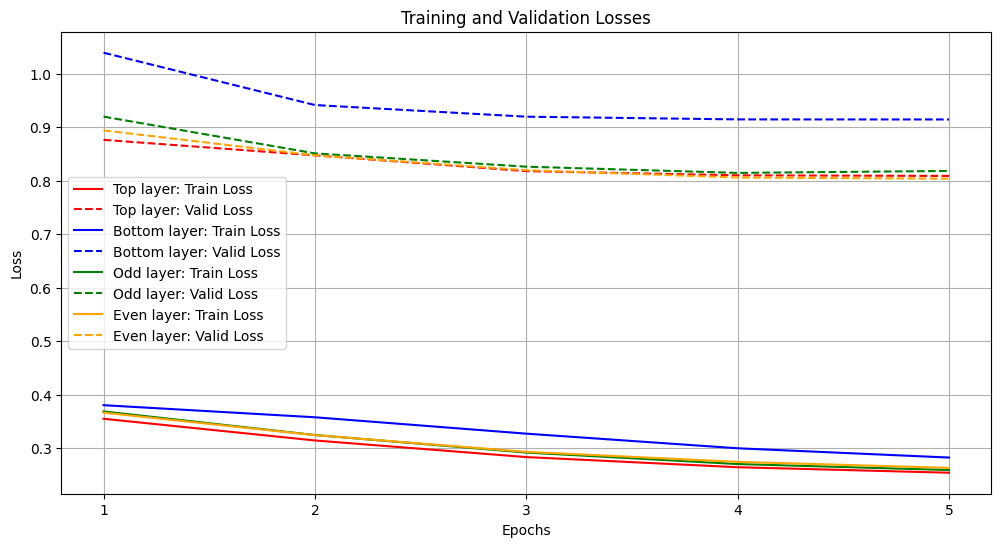

In [43]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

color_lists = ['red', 'blue', 'green', 'orange']

for i, mode in enumerate(losses.keys()):
    plt.plot(epochs_list, losses[mode]['train_losses'], label=f'{mode.capitalize()}: Train Loss', color=color_lists[i])
    plt.plot(epochs_list, losses[mode]['eval_losses'], label=f'{mode.capitalize()}: Valid Loss', color=color_lists[i], linestyle='--')

plt.title('Training and Validation Losses')
plt.xticks(epochs_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(f'{file_path}/compared_losses.png')
plt.show()

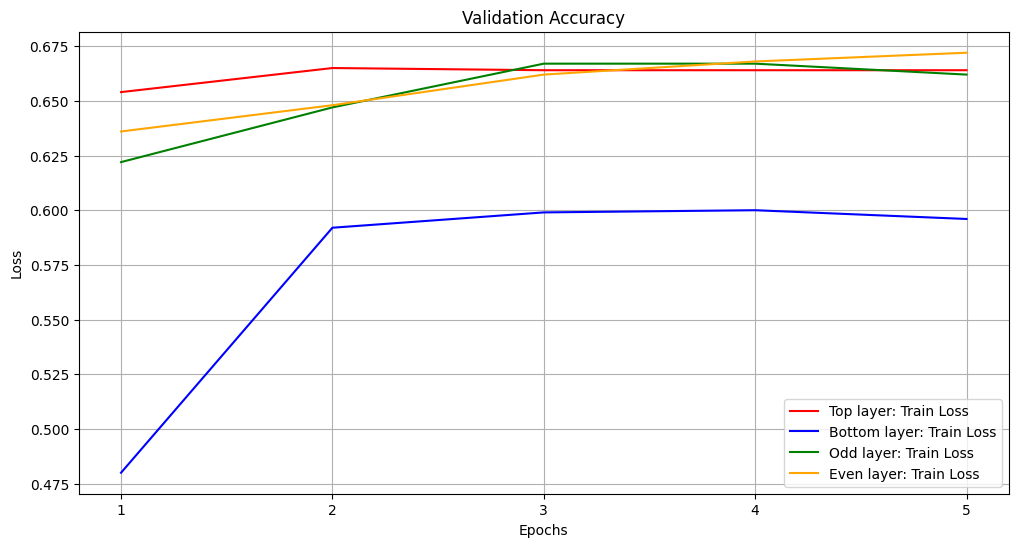

In [44]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

color_lists = ['red', 'blue', 'green', 'orange']

for i, mode in enumerate(losses.keys()):
    plt.plot(epochs_list, losses[mode]['eval_accs'], label=f'{mode.capitalize()}: Train Loss', color=color_lists[i])

plt.title('Validation Accuracy')
plt.xticks(epochs_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(f'{file_path}/compared_accs.png')
plt.show()

### Appendix (Teacher Model)

In [45]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')

    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy']
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/785 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.8380:
Epoch at 1: Test Acc 0.7090
Epoch at 2: Train loss 0.4992:
Epoch at 2: Test Acc 0.7280
Epoch at 3: Train loss 0.2423:
Epoch at 3: Test Acc 0.7420
Epoch at 4: Train loss 0.1161:
Epoch at 4: Test Acc 0.7310
Epoch at 5: Train loss 0.0747:
Epoch at 5: Test Acc 0.7370
Avg Metric 0.7293999999999999
